# Random Forest para tarefas de classificação e regressão

**Motivação** <br>
• RF de classificação<br>
•RF de regressão<br>
•Importância das variáveis<br>
•Avaliação dos modelos<br>
•Você pode visualizar sua floresta?

In [70]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as metrics
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline


In [71]:
import os
os.chdir("C:\\Users\\dalto\\OpM na Prática\\Python\\Base de Dados")

wine = pd.read_csv("winequality-red.csv", sep = ";")
wine = wine.drop([1598])

wine.shape

(1598, 12)

In [72]:
baseCC = pd.read_csv("cc_approvals.data", header = None)

baseCC.shape

(690, 16)

# Wine - tratamento da base como feito na aula 2

In [73]:
correlT = wine.corr().abs()
# Como o heatmap é uma matriz triangular espelhada, usa-se essa linha para remover os valores repetidos
superior = correlT.where(np.triu(np.ones(correlT.shape), k=1).astype(bool))
# Remove todas as colunas que tem correlação superior a 0.5 entre si
var_remove = [variaveis for variaveis in superior.columns if any(superior[variaveis] > 0.5)]

wine = wine.drop(wine[var_remove], axis = 1)

xWine = wine.drop('quality', axis = 1)
yWine = wine['quality']

xTrainW, xTestW, yTrainW, yTestW = train_test_split(xWine, yWine, test_size = 0.50, random_state=42)

# CC - Tratamento da base como feito na aula 3

In [74]:
# Substituindo "?" e verificando se está tudo ok

baseCC = baseCC.replace("?", np.NaN)
baseCC = baseCC.fillna( method = 'ffill')
baseCC = baseCC.drop([baseCC.columns[13]], axis = 1)
baseCC.columns = ["var1", "var2", "var3", "var4", "var5", "var6", "var7"
                  , "var8", "var9", "var10", "var11", "var12", "var13", "var14", "alvo"]

encoder = LabelEncoder()

# Percorrendo e transformando toda a base de dados
for variaveis in baseCC.columns:
    if baseCC[variaveis].dtype =='object':
        baseCC[variaveis] = encoder.fit_transform(baseCC[variaveis])
        
# Cria intervalos da variável var2
var2X = list(range(baseCC.var2.min(), baseCC.var2.max()+50, 50))
# Cria o nome dos intervalos
nomeX = [f'var_i{i}' for i in range(len(var2X)-1)]
# Atribui ao data frame
baseCC['var2X'] =  pd.cut(baseCC.var2, var2X, labels = nomeX, include_lowest = True)
baseCC = baseCC.fillna(method = 'ffill')
baseCC = baseCC.drop("var2", axis = 1)

categorias = {"var2X": {"var_i0": 0 ,"var_i1": 1, "var_i2": 2 ,"var_i3": 3 ,"var_i4": 4 ,"var_i5": 5,"var_i6": 6 }}
baseCC.replace(categorias,inplace = True)

xCC = baseCC.drop("alvo", axis = 1)
yCC = baseCC["alvo"]

xTrainCC, xTestCC, yTrainCC, yTestCC = train_test_split(xCC, yCC, test_size = 0.50, random_state=42)

# RF para tarefa de regressão - Utilizando base Wine

In [75]:
#Treinando o modelo

#depth 3-> 5 ; estimatores 1000 -> 2000
rfWine = RandomForestRegressor (bootstrap = True,
                               criterion = 'mse', max_depth = 3, max_features = 'auto',
                               min_samples_leaf = 1, min_samples_split = 2,
                                n_estimators = 1000, n_jobs = 5, oob_score = True)
rfWine.fit(xTrainW, yTrainW)

RandomForestRegressor(max_depth=3, n_estimators=1000, n_jobs=5, oob_score=True)

In [76]:
# Predições para treinamento e teste
predTrainW = rfWine.predict(xTrainW)
predTestW = rfWine.predict(xTestW)


In [77]:
MAEtrainW = metrics.mean_absolute_error(yTrainW, predTrainW)
R2trainW = metrics.r2_score(yTrainW, predTrainW)
RMSEtrainW = sqrt(metrics.mean_squared_error(yTrainW, predTrainW))

print("----- Avaliação do treinamento -----")
print("MAE: ", round(MAEtrainW, 2))
print("R2: ", round(R2trainW, 2))
print("RMSE: ", round(RMSEtrainW, 2))


MAEtestW = metrics.mean_absolute_error(yTestW, predTestW)
R2testW = metrics.r2_score(yTestW, predTestW)
RMSEtestW = sqrt(metrics.mean_squared_error(yTestW, predTestW))

print("----- Avaliação do treinamento -----")
print("MAE: ", round(MAEtestW, 2))
print("R2: ", round(R2testW, 2))
print("RMSE: ", round(RMSEtestW, 2))

----- Avaliação do treinamento -----
MAE:  0.49
R2:  0.42
RMSE:  0.62
----- Avaliação do treinamento -----
MAE:  0.52
R2:  0.36
RMSE:  0.64


In [78]:
print("A qualidade média de vinho da base e: ")
print(round(yTestW.mean(),2))
print()
print("O percentual do MAE em relação à média da base: ")
print(round(metrics.mean_absolute_error(yTestW, predTestW)/yTestW.mean()*100,2),"%")

A qualidade média de vinho da base e: 
5.65

O percentual do MAE em relação à média da base: 
9.28 %


In [79]:
# Analisando a importância das variáveis

rfWine.feature_importances_

array([0.01718955, 0.20519228, 0.01409557, 0.00888178, 0.01178888,
       0.17222296, 0.57062898])

In [80]:
# Atribuindo o nome às variáveis
imp = pd.DataFrame ({'Variáveis' : xTrainW.columns, 'Importância' : rfWine.feature_importances_})

#Colocando o sort pela importância
print(imp.sort_values(by=['Importância'], ascending = False))

             Variáveis  Importância
6              alcohol     0.570629
1     volatile acidity     0.205192
5            sulphates     0.172223
0        fixed acidity     0.017190
2       residual sugar     0.014096
4  free sulfur dioxide     0.011789
3            chlorides     0.008882


In [81]:
imp = imp.sort_values(by=['Importância'], ascending = False)

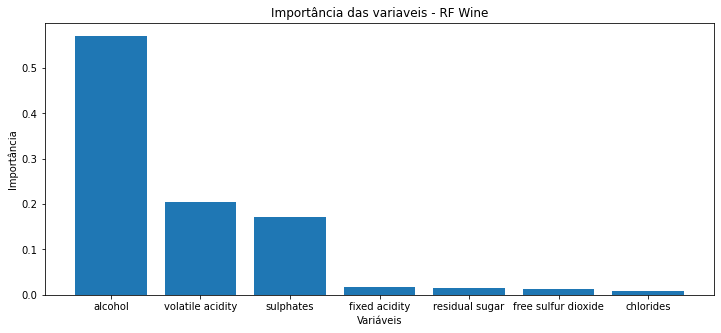

In [82]:
plt.figure(figsize= (12,5))
plt.xticks(range(len(imp)), imp['Variáveis'])
plt.xlabel('Variáveis')
plt.ylabel('Importância')
plt.title("Importância das variaveis - RF Wine")
plt.bar(range(len(imp)), imp['Importância']);

In [83]:
# Retreinando o modelo apenas com as variáveis mais importantes

wine2 = wine.loc[:,["alcohol","sulphates", "volatile acidity", "quality"]]

xWine2 = wine2.drop('quality', axis = 1)
yWine2 = wine2['quality']

xTrainW2, xTestW2, yTrainW2, yTestW2 = train_test_split(xWine2, yWine2, test_size = 0.50, random_state=42)

In [84]:
rfW2 = RandomForestRegressor (bootstrap = True,
                               criterion = 'mse', max_depth = 3, max_features = 'auto',
                               min_samples_leaf = 1, min_samples_split = 2,
                                n_estimators = 1000, n_jobs = 5, oob_score = True)
rfW2.fit(xTrainW2, yTrainW2)


predTrainW2 = rfW2.predict(xTrainW2)
predTestW2 = rfW2.predict(xTestW2)

In [85]:
MAEtrainW2= metrics.mean_absolute_error(yTrainW2, predTrainW2)
R2trainW2 = metrics.r2_score(yTrainW2, predTrainW2)
RMSEtrainW2 = sqrt(metrics.mean_squared_error(yTrainW2, predTrainW2))

print("----- Avaliação do treinamento 2 -----")
print("MAE: ", round(MAEtrainW2, 2))
print("R2: ", round(R2trainW2, 2))
print("RMSE: ", round(RMSEtrainW2, 2))

----- Avaliação do treinamento 2 -----
MAE:  0.49
R2:  0.41
RMSE:  0.62


In [86]:
print("A qualidade média de vinho da base e: ")
print(round(yTestW2.mean(),2))
print()
print("O percentual do MAE em relação à média da base: ")
print(round(metrics.mean_absolute_error(yTestW2, predTestW2)/yTestW2.mean()*100,2),"%")

A qualidade média de vinho da base e: 
5.65

O percentual do MAE em relação à média da base: 
9.26 %


# RF para treinamento de regressão - Utilizando CC

In [88]:
rfCC = RandomForestClassifier (bootstrap = True,
                               criterion = 'gini', max_depth = 3, max_features = 'auto',
                               min_samples_leaf = 1, min_samples_split = 2,
                                n_estimators = 1500, n_jobs = 5, oob_score = True)

rfCC.fit(xTrainCC, yTrainCC)

RandomForestClassifier(max_depth=3, n_estimators=1500, n_jobs=5, oob_score=True)

In [90]:
predTrainCC = rfCC.predict(xTrainCC)
predTestCC = rfCC.predict(xTestCC)


In [91]:
# Calculando a ROC e o Gini - Treinamento
fprTrainCC, tprTrainCC, thresholdsTrainCC = roc_curve(yTrainCC, predTrainCC)
roc_auc_trainCC = auc(fprTrainCC, tprTrainCC)

print('AUC - Treinamento : %f' % roc_auc_trainCC)
print("Gini - Treinamento: ", round(2*roc_auc_trainCC-1,2))
print()

# Calculando a ROC e o Gini - Treinamento
fprTestCC, tprTestCC, thresholdsTestCC = roc_curve(yTestCC, predTestCC)
roc_auc_testCC = auc(fprTestCC, tprTestCC)

print('AUC - Treinamento : %f' % roc_auc_testCC)
print("Gini - Treinamento: ", round(2*roc_auc_testCC-1,2))

AUC - Treinamento : 0.880566
Gini - Treinamento:  0.76

AUC - Treinamento : 0.875586
Gini - Treinamento:  0.75


In [92]:
impCC = pd.DataFrame({'Variáveis' : xTrainCC.columns, 'Importância' : rfCC.feature_importances_})

print(impCC.sort_values(by=['Importância'], ascending = False))

   Variáveis  Importância
7       var9     0.381392
9      var11     0.147123
6       var8     0.122132
12     var14     0.103248
8      var10     0.094576
4       var6     0.046501
1       var3     0.044283
5       var7     0.013691
13     var2X     0.013553
2       var4     0.011055
3       var5     0.010005
11     var13     0.006659
10     var12     0.003644
0       var1     0.002138


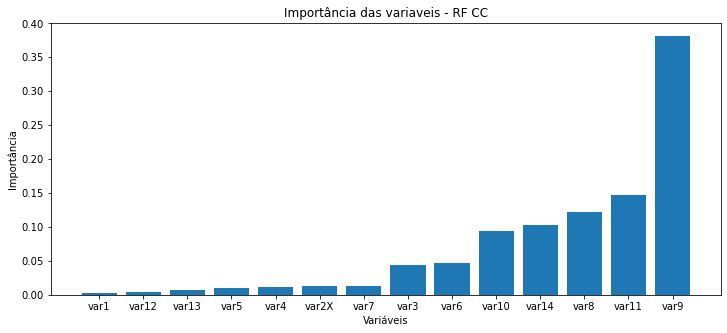

In [94]:
impCC = impCC.sort_values(by=['Importância'])
plt.figure(figsize= (12,5))
plt.xticks(range(len(impCC)), impCC['Variáveis'])
plt.xlabel('Variáveis')
plt.ylabel('Importância')
plt.title("Importância das variaveis - RF CC")
plt.bar(range(len(impCC)), impCC['Importância']);

In [ ]:
#ECERCÍCIO - Treinar apenas com as variáveis mais importantes

In [95]:
os.environ["PATH"] += os.pathsep + 'C:\Program Files (x86)\Graphviz2.38\bin'

In [96]:
arvore = rfCC.estimators_[42]
# Ao chamar essa função, consultamos apenas uma das árvores de decisão de toda a floresta

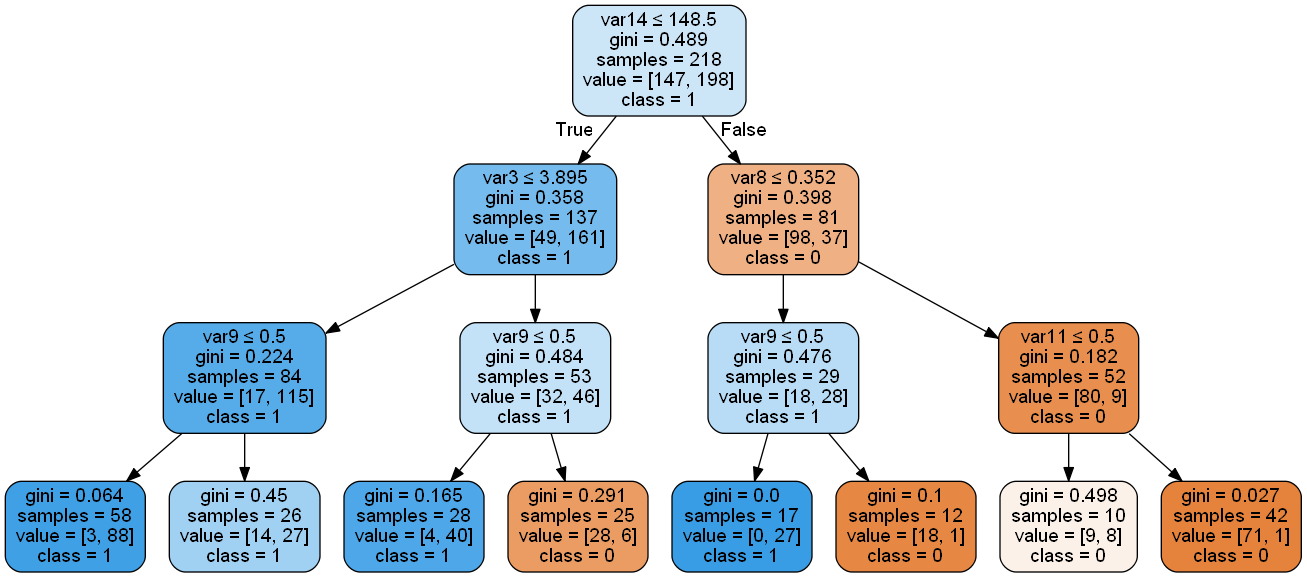

In [98]:
from six import StringIO #from sklearn.externals.six import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()

export_graphviz(arvore
                , out_file = dot_data
                , filled = True
                , rounded = True
                , special_characters = True
                , feature_names = baseCC.columns[0:14]
                , class_names = ['0', '1'])

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

Image(graph.create_png())